# Importar Módulos

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn import preprocessing
from IPython.display import display

# Formatear como los datos van a salir
### No más de 10 impresas y con 3 decimales

In [15]:
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.3f}".format

# Preparación de datos

In [16]:
#importar dataset
training_df = pd.read_csv('train_validation.csv')
test_df = pd.read_csv('test.csv')

In [17]:
#aleatorize el dataset
shuffled_training_df = training_df.reindex(np.random.permutation(training_df.index))
shuffled_test_df = test_df.reindex(np.random.permutation(test_df.index))
shuffled_test_df

,wconfid,pctid,x,y,z
69973,2,50,0.988,0.184,-0.148
100951,2,100,0.840,-0.410,-0.871
144976,3,90,0.777,-0.098,0.086
115963,3,40,1.012,0.098,-0.129
6324,1,30,0.988,0.078,-0.105
...,...,...,...,...,...
6936,1,30,0.984,0.117,-0.148
26709,1,60,0.930,0.027,-0.055
139890,3,80,1.016,-0.063,-0.133
79412,2,65,0.992,0.152,-0.039


# Revisar por datos no numéricos y outliers

,wconfid,pctid,x,y,z
count,122400.000,122400.000,122400.000,122400.000,122400.000
mean,2.250,64.240,0.995,0.005,-0.116
std,0.722,24.615,0.864,0.822,0.573
min,1.000,20.000,-8.000,-8.000,-5.867
25%,2.000,45.000,0.938,-0.082,-0.180
50%,2.000,70.000,0.992,0.008,-0.121
75%,3.000,85.000,1.043,0.109,-0.059
max,3.000,100.000,7.996,7.996,6.086


wconfid    0
pctid      0
x          0
y          0
z          0
dtype: int64

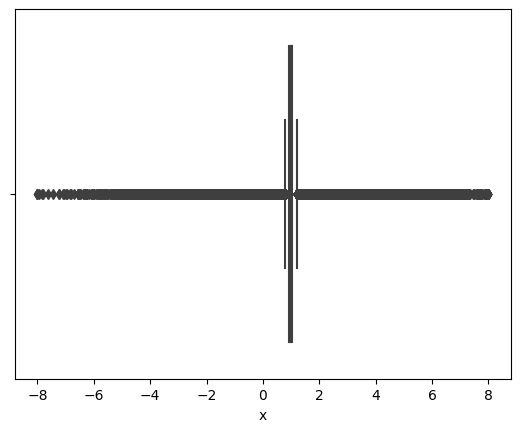

In [18]:

display(shuffled_training_df.describe())#da mean, std, min, cuantiles 25,50,75%, max

display(shuffled_training_df.isna().sum())#dice si hay valores en blanco o no numericos

sns.boxplot(x=shuffled_training_df['x'])#boxplot en wconfid para ver si hay outliers

#z = np.abs(stats.zscore(shuffled_test_df))
#display(np.where(z>3))

plt.show()

# Normalización

In [19]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

norm_training = pd.DataFrame(scaler.fit_transform(shuffled_training_df))
norm_training.columns=['wconfid','pctid','x','y','z']

norm_test = pd.DataFrame(scaler.fit_transform(shuffled_test_df))
norm_test.columns=['wconfid','pctid','x','y','z']

inv = scaler.fit(shuffled_test_df)
display(norm_test.describe())

,wconfid,pctid,x,y,z
count,153000.000,153000.000,153000.000,153000.000,153000.000
mean,0.000,0.000,0.125,0.001,-0.038
std,0.816,0.612,0.097,0.093,0.087
min,-1.000,-1.000,-1.000,-1.000,-1.000
25%,-1.000,-0.500,0.118,-0.010,-0.047
50%,0.000,0.000,0.124,0.001,-0.039
75%,1.000,0.500,0.130,0.013,-0.029
max,1.000,1.000,1.000,1.000,1.000


# Dividir features y labels

In [20]:
train_features = norm_training[['wconfid','pctid']]
train_labels = norm_training[['x','y','z']]

test_features = norm_test[['wconfid','pctid']]
test_labels = norm_test[['x','y','z']]
display(test_features)
display(test_labels)

,wconfid,pctid
0,0.000,-0.250
1,0.000,1.000
2,1.000,0.750
3,1.000,-0.500
4,-1.000,-0.750
...,...,...
152995,-1.000,-0.750
152996,-1.000,0.000
152997,1.000,0.500
152998,0.000,0.125


,x,y,z
0,0.124,0.023,-0.043
1,0.105,-0.051,-0.164
2,0.097,-0.012,-0.004
3,0.127,0.013,-0.040
4,0.124,0.010,-0.036
...,...,...,...
152995,0.123,0.015,-0.043
152996,0.117,0.004,-0.028
152997,0.127,-0.008,-0.041
152998,0.124,0.019,-0.025


# Creación del modelo

In [21]:
def my_model(my_learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(3, input_shape=(2,), activation='tanh'), #se hace una hidden layer de 3 neuronas con activacion sigmoid
        tf.keras.layers.Dense(3) #capa de output
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="mean_squared_error", #funcion de perdida
                metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.Accuracy()] #funcion de metricas para evaluar
                )
    return model
model = my_model(0.01)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 3)                 9         
                                                                 
 dense_5 (Dense)             (None, 3)                 12        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


# Entrenamiento del Modelo

In [22]:
def train_model(model, features, labels, epochs, batch_size):
    
    early_stop= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10) #patience es la cant de epochs antes de chequear el improvement
    history = model.fit(
        x=features,
        y=labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.25,
        callbacks = early_stop
    )
    hist= pd.DataFrame(history.history) #se guardan los valores de errores y metricas en un diccionario
    hist['epoch'] = history.epoch #los epochs se deben añadir aparte
    mse = hist['mean_squared_error']
    
    return hist, mse

# Ploteo de gráficas

In [23]:
def plot_loss_curve(history):
    hist = history
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error', c='r')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label='Validation Error', c='b')
    
    plt.legend()
    plt.ylim([0.9,1.2])
    plt.show()

# Hyperparámetros

In [24]:
learning_rate = 0.01
epochs = 50
batch_size = 100

# Llamado de funciones

Epoch 1/50
918/918 [==============================] - 2s 2ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - accuracy: 0.0000e+00 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_accuracy: 0.0000e+00
Epoch 2/50
918/918 [==============================] - 2s 2ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - accuracy: 0.0000e+00 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_accuracy: 0.0000e+00
Epoch 3/50
918/918 [==============================] - 2s 2ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - accuracy: 0.0000e+00 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_accuracy: 0.0000e+00
Epoch 4/50
918/918 [==============================] - 1s 2ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - accuracy: 0.0000e+00 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_accuracy: 0.0000e+00
Epoch 5/50
918/918 [==============================] - 1s 2ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - accuracy: 0.0000e+00 - val_loss: 0.0106 

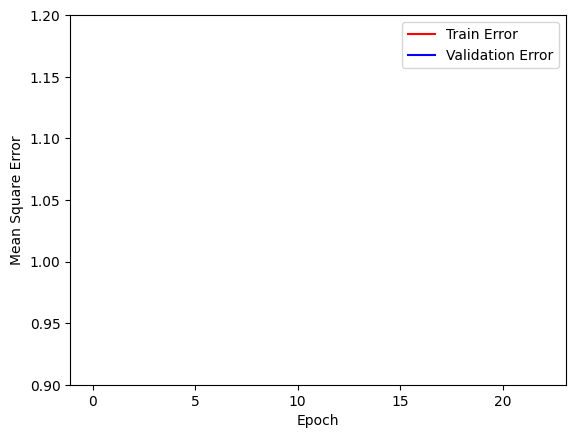

,loss,mean_squared_error,accuracy,val_loss,val_mean_squared_error,val_accuracy,epoch
0,0.014,0.014,0.000,0.011,0.011,0.000,0
1,0.011,0.011,0.000,0.011,0.011,0.000,1
2,0.011,0.011,0.000,0.011,0.011,0.000,2
3,0.011,0.011,0.000,0.011,0.011,0.000,3
4,0.011,0.011,0.000,0.011,0.011,0.000,4
...,...,...,...,...,...,...,...
18,0.011,0.011,0.000,0.011,0.011,0.000,18
19,0.011,0.011,0.000,0.011,0.011,0.000,19
20,0.011,0.011,0.000,0.011,0.011,0.000,20
21,0.011,0.011,0.000,0.011,0.011,0.000,21


In [25]:
model = my_model(learning_rate)
history, mse = train_model(model, train_features, train_labels, epochs, batch_size)
plot_loss_curve(history)
display(history)

# Predicciones

In [26]:
test_predictions_arr = np.array(model.predict(test_features))
test_predictions_arr = np.append(test_predictions_arr, np.zeros(shape=(len(test_df), 2)), axis=1)

test_predictions_df = pd.DataFrame(test_predictions_arr, columns=['predictions x', 'predictions y', 'predictions z', 'z1', 'z2'])
test_predictions_df.shape
#norm_test.shape
#inv.inverse_transform(test_predictions_df)
inv_test_predictions_df = pd.DataFrame(inv.inverse_transform(test_predictions_df), columns=['predictions x', 'predictions y', 'predictions z', 'z1', 'z2'])

inv_test_data = pd.DataFrame(inv.inverse_transform(norm_test), columns=['wconfid', 'pctid', 'x', 'y', 'z'])

results = pd.concat([inv_test_data, inv_test_predictions_df[['predictions x', 'predictions y', 'predictions z']]], axis=1, join='inner')
display(results)


4782/4782 [==============================] - 5s 959us/step


,wconfid,pctid,x,y,z,predictions x,predictions y,predictions z
0,2.000,50.000,0.988,0.184,-0.148,2.125,59.746,-0.323
1,2.000,100.000,0.840,-0.410,-0.871,2.125,59.466,-0.285
2,3.000,90.000,0.777,-0.098,0.086,2.125,59.681,-0.321
3,3.000,40.000,1.012,0.098,-0.129,2.126,59.961,-0.360
4,1.000,30.000,0.988,0.078,-0.105,2.125,59.700,-0.309
...,...,...,...,...,...,...,...,...
152995,1.000,30.000,0.984,0.117,-0.148,2.125,59.700,-0.309
152996,1.000,60.000,0.930,0.027,-0.055,2.125,59.532,-0.286
152997,3.000,80.000,1.016,-0.063,-0.133,2.125,59.737,-0.329
152998,2.000,65.000,0.992,0.152,-0.039,2.125,59.662,-0.311
